<a href="https://colab.research.google.com/github/agarr3/vajra-new-2/blob/main/AE_HYBRID_GTZAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss(reduction="mean")
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1



DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/"
DATA_SONG_DIR = "originals"
DATA_IMG_DIR = "originals"
input_bins = 48
BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/"



seq_len=200
AE_encoded_dim = 64

class_level_loss_mode = "test"

print(device)

cuda:0


In [3]:
from google.colab import drive
drive._mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
print(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "Western_numpy"))
             
train_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      train_files.append([file,file, "Western_numpy"])
    else:
      print(file)



for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", "Indian_numpy")):
  for file in fileList:
    if(True):
      train_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

train_data = pd.DataFrame(train_files, columns=['Images','songs','labels'])
train_data.head()

/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/originals/Western_numpy


,Images,songs,labels
0,western_147022_mel_1.npy,western_147022_mel_1.npy,Western_numpy
1,western_040182_mel_0.npy,western_040182_mel_0.npy,Western_numpy
2,western_133942_mel_0.npy,western_133942_mel_0.npy,Western_numpy
3,western_024912_mel_0.npy,western_024912_mel_0.npy,Western_numpy
4,western_130369_mel_1.npy,western_130369_mel_1.npy,Western_numpy


In [5]:
test_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      test_files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
test_files = random.sample(test_files, len(test_files))

for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", "Indian_numpy")):
  for file in fileList:
    if(True):
      test_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

test_data = pd.DataFrame(test_files, columns=['Images','songs','labels'])
test_data.head()

,Images,songs,labels
0,western_130993_mel_0.npy,western_130993_mel_0.npy,Western_numpy
1,western_120189_mel_1.npy,western_120189_mel_1.npy,Western_numpy
2,western_111579_mel_1.npy,western_111579_mel_1.npy,Western_numpy
3,western_111793_mel_1.npy,western_111793_mel_1.npy,Western_numpy
4,western_122503_mel_1.npy,western_122503_mel_1.npy,Western_numpy


In [6]:
EXT_DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins"
EXT_DATA_SONG_DIR = "Chunked"
EXT_DATA_IMG_DIR = "Chunked"

gt_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(EXT_DATA_BASE_PATH, EXT_DATA_IMG_DIR, "GTZAN_mel")):
  for file in fileList:
    if(file not in exclusion):
      gt_files.append([os.path.join( r,file), file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
gt_files = random.sample(gt_files, len(gt_files))

gt_data = pd.DataFrame(gt_files, columns=['path', 'fileName', 'labels'])
gt_data.head()

,path,fileName,labels
0,/content/gdrive/My Drive/vajra/songs-vajra-dat...,metal.00009_mel_1.npy,Western_numpy
1,/content/gdrive/My Drive/vajra/songs-vajra-dat...,reggae.00022_mel_2.npy,Western_numpy
2,/content/gdrive/My Drive/vajra/songs-vajra-dat...,metal.00071_mel_1.npy,Western_numpy
3,/content/gdrive/My Drive/vajra/songs-vajra-dat...,pop.00095_mel_0.npy,Western_numpy
4,/content/gdrive/My Drive/vajra/songs-vajra-dat...,classical.00094_mel_0.npy,Western_numpy


In [7]:
train_data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,2811,2811
Western_numpy,2800,2800


In [8]:
test_data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,1205,1205
Western_numpy,1200,1200


In [9]:
gt_data.groupby("labels").count()

,path,fileName
labels,,
Western_numpy,2988,2988


/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/originals/test/Western_numpy/western_125193_mel_0.npy
80.0


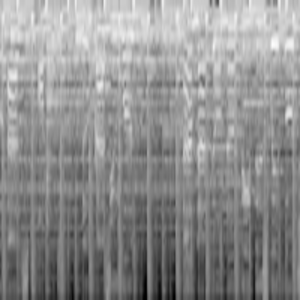

In [10]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", test_data.loc[test_idx, 'labels'], test_data.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



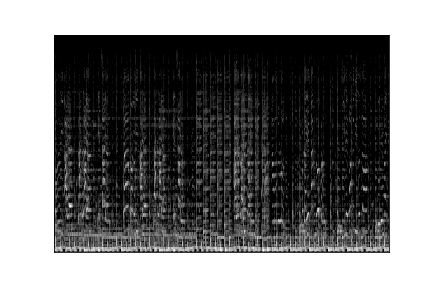

In [11]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [12]:
lb = LabelEncoder()
train_data['encoded_labels'] = lb.fit_transform(train_data['labels'])
train_data.head()

,Images,songs,labels,encoded_labels
0,western_147022_mel_1.npy,western_147022_mel_1.npy,Western_numpy,1
1,western_040182_mel_0.npy,western_040182_mel_0.npy,Western_numpy,1
2,western_133942_mel_0.npy,western_133942_mel_0.npy,Western_numpy,1
3,western_024912_mel_0.npy,western_024912_mel_0.npy,Western_numpy,1
4,western_130369_mel_1.npy,western_130369_mel_1.npy,Western_numpy,1


In [13]:
test_data['encoded_labels'] = lb.transform(test_data['labels'])
test_data.head()

,Images,songs,labels,encoded_labels
0,western_130993_mel_0.npy,western_130993_mel_0.npy,Western_numpy,1
1,western_120189_mel_1.npy,western_120189_mel_1.npy,Western_numpy,1
2,western_111579_mel_1.npy,western_111579_mel_1.npy,Western_numpy,1
3,western_111793_mel_1.npy,western_111793_mel_1.npy,Western_numpy,1
4,western_122503_mel_1.npy,western_122503_mel_1.npy,Western_numpy,1


In [14]:
gt_data['encoded_labels'] = lb.transform(gt_data['labels'])
gt_data.head()

,path,fileName,labels,encoded_labels
0,/content/gdrive/My Drive/vajra/songs-vajra-dat...,metal.00009_mel_1.npy,Western_numpy,1
1,/content/gdrive/My Drive/vajra/songs-vajra-dat...,reggae.00022_mel_2.npy,Western_numpy,1
2,/content/gdrive/My Drive/vajra/songs-vajra-dat...,metal.00071_mel_1.npy,Western_numpy,1
3,/content/gdrive/My Drive/vajra/songs-vajra-dat...,pop.00095_mel_0.npy,Western_numpy,1
4,/content/gdrive/My Drive/vajra/songs-vajra-dat...,classical.00094_mel_0.npy,Western_numpy,1


In [15]:
classes = ('Indian_numpy', 'Western_numpy')
train_data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2811,2811
Western_numpy,1,2800,2800


In [16]:
test_data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205
Western_numpy,1,1200,1200


In [17]:
gt_data.groupby(by=['labels','encoded_labels']).count()

,,path,fileName
labels,encoded_labels,,
Western_numpy,1,2988,2988


In [18]:
from sklearn.model_selection import train_test_split

train_data_combined = train_data.copy(deep=True)
test_data_combined = test_data.copy(deep=True)

# train_data = train_data[train_data['labels'] == "Western_numpy"]
# test_data = test_data[test_data['labels'] == "Western_numpy"]


df_train, df_test = train_test_split(gt_data, test_size=validation_split, stratify=gt_data[["labels"]])

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [19]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,path,fileName
labels,encoded_labels,,
Western_numpy,1,2091,2091


In [20]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,path,fileName
labels,encoded_labels,,
Western_numpy,1,897,897


In [21]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [22]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        fileName = self.img_data.loc[index, 'Images']
        return data, label, fileName



In [23]:
class MEL_Dataset_EXT(Dataset):
    def __init__(self, img_data,transform=None):
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = self.img_data.loc[index, 'path']
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        
        fileName = self.img_data.loc[index, 'fileName']
        return data, label, fileName

In [24]:
train_dataset = MEL_Dataset_EXT(df_train, transform)
test_dataset = MEL_Dataset_EXT(df_test,transform)

train_dataset_combined = MEL_Dataset(train_data_combined,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training"),transform)
test_dataset_combined = MEL_Dataset(test_data_combined,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test"),transform)

In [25]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

trainloader_combined = torch.utils.data.DataLoader(train_dataset_combined, batch_size=batch_size)
testloader_combined = torch.utils.data.DataLoader(test_dataset_combined, batch_size=batch_size)

In [26]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

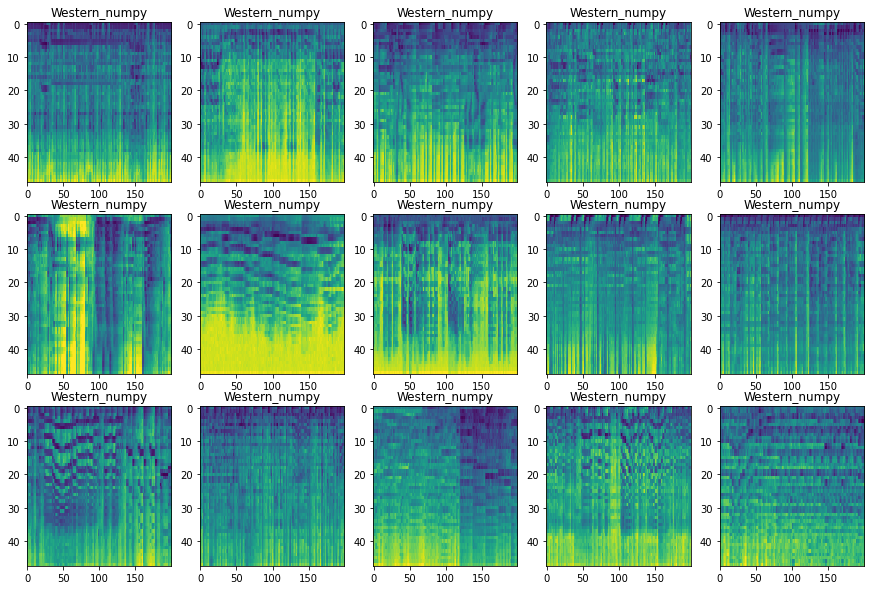

In [30]:
# get some random training images
dataiter = iter(trainloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

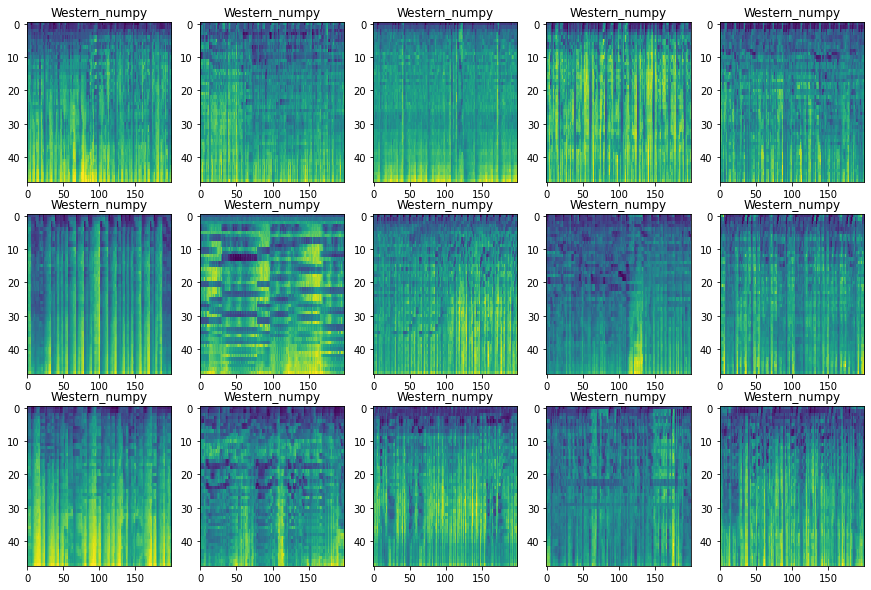

In [31]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

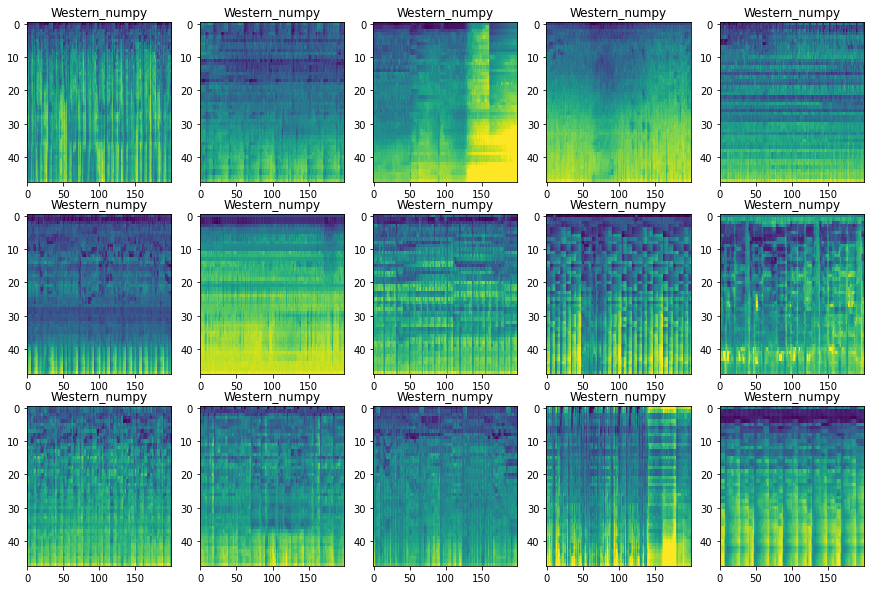

In [32]:
# get some random training images
dataiter = iter(trainloader_combined)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [33]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [34]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


def visualize_class_loss(in_loss_graph, we_loss_graph):
  x = range(len(in_loss_graph))
      
  # plot lines
  plt.plot(x, in_loss_graph, label = "Indian Loss")
  plt.plot(x, we_loss_graph, label = "Western Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1541.736
[1,     2] loss: 1356.449
[1,     4] loss: 1195.639
[1,     5] loss: 1127.919
[1,     6] loss: 863.324
[1,     7] loss: 703.262
[1,     8] loss: 494.578
[1,     9] loss: 209.471
[1,    10] loss: 300.980
[1,    11] loss: 340.120
[1,    12] loss: 167.225
[1,    13] loss: 152.088
[1,    14] loss: 145.718
[1,    15] loss: 155.631
[1,    16] loss: 152.251
[1,    17] loss: 148.035
[1,    18] loss: 146.033
[1,    19] loss: 142.798
[1,    20] loss: 128.904
[1,    21] loss: 130.049
[1,    22] loss: 146.277
[1,    23] loss: 158.971
[1,    24] loss: 123.392
[1,    25] loss: 140.432
[1,    26] loss: 113.640
[1,    27] loss: 124.670
[1,    28] loss: 111.690
[1,    29] loss: 167.294
[1,    30] loss: 138.260
[1,    31] loss: 115.656
[1,    32] loss: 142.574
[1,    33] loss: 106.018
LOSS of the network on the train images after epoch 0 is 12527.664993286133
Mean of the network on the train images after epoch 0 is 391.48953104019165
LOSS of the network on the test images: 1734

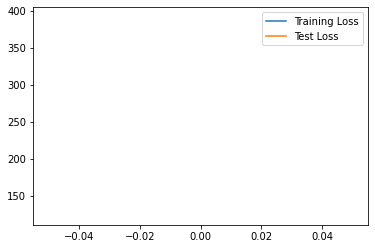

[2,     1] loss: 122.539
[2,     2] loss: 121.001
[2,     3] loss: 116.546
[2,     4] loss: 119.807
[2,     5] loss: 132.509
[2,     6] loss: 112.585
[2,     7] loss: 106.073
[2,     8] loss: 120.510
[2,     9] loss: 104.058
[2,    10] loss: 119.701
[2,    11] loss: 109.013
[2,    12] loss: 119.396
[2,    13] loss: 151.926
[2,    14] loss: 123.744
[2,    15] loss: 115.837
[2,    16] loss: 102.851
[2,    17] loss: 115.276
[2,    18] loss: 110.405
[2,    19] loss: 124.801
[2,    20] loss: 112.939
[2,    21] loss: 112.648
[2,    22] loss: 116.928
[2,    23] loss: 96.571
[2,    24] loss: 95.231
[2,    25] loss: 132.286
[2,    26] loss: 98.448
[2,    27] loss: 115.855
[2,    28] loss: 98.378
[2,    29] loss: 132.231
[2,    30] loss: 113.801
[2,    31] loss: 113.087
[2,    32] loss: 118.400
[2,    33] loss: 102.452
LOSS of the network on the train images after epoch 1 is 3807.832099914551
Mean of the network on the train images after epoch 1 is 118.99475312232971
LOSS of the network on the t

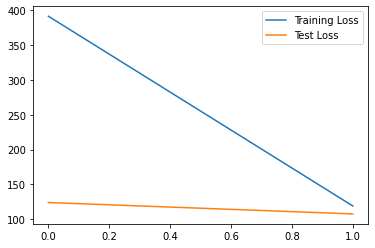

[3,     1] loss: 108.172
[3,     2] loss: 102.899
[3,     3] loss: 104.664
[3,     4] loss: 99.644
[3,     5] loss: 101.861
[3,     6] loss: 86.859
[3,     7] loss: 86.360
[3,     8] loss: 90.375
[3,     9] loss: 79.065
[3,    10] loss: 85.734
[3,    11] loss: 75.709
[3,    12] loss: 74.824
[3,    13] loss: 84.964
[3,    14] loss: 72.128
[3,    15] loss: 77.268
[3,    16] loss: 75.761
[3,    17] loss: 75.450
[3,    18] loss: 78.382
[3,    19] loss: 76.867
[3,    20] loss: 69.051
[3,    21] loss: 81.400
[3,    22] loss: 66.894
[3,    23] loss: 63.881
[3,    24] loss: 70.068
[3,    25] loss: 76.774
[3,    26] loss: 66.555
[3,    27] loss: 70.652
[3,    28] loss: 73.937
[3,    29] loss: 88.158
[3,    30] loss: 71.718
[3,    31] loss: 71.480
[3,    32] loss: 78.936
[3,    33] loss: 70.941
LOSS of the network on the train images after epoch 2 is 2657.4331130981445
Mean of the network on the train images after epoch 2 is 83.04478478431702
LOSS of the network on the test images: 1064 %
Mean o

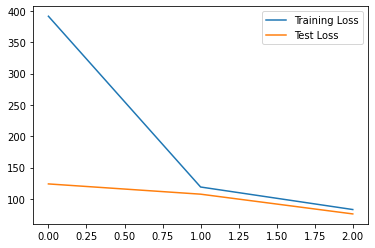

[4,     1] loss: 82.346
[4,     2] loss: 70.507
[4,     3] loss: 73.534
[4,     4] loss: 76.219
[4,     5] loss: 74.537
[4,     6] loss: 68.387
[4,     7] loss: 67.854
[4,     8] loss: 73.137
[4,     9] loss: 68.271
[4,    10] loss: 68.364
[4,    11] loss: 68.158
[4,    12] loss: 70.557
[4,    13] loss: 78.566
[4,    14] loss: 69.983
[4,    15] loss: 71.730
[4,    16] loss: 70.128
[4,    17] loss: 70.281
[4,    18] loss: 73.107
[4,    19] loss: 73.435
[4,    20] loss: 65.435
[4,    21] loss: 78.055
[4,    22] loss: 64.596
[4,    23] loss: 62.551
[4,    24] loss: 68.360
[4,    25] loss: 74.239
[4,    26] loss: 63.438
[4,    27] loss: 69.877
[4,    28] loss: 72.441
[4,    29] loss: 84.179
[4,    30] loss: 68.858
[4,    31] loss: 69.304
[4,    32] loss: 76.003
[4,    33] loss: 69.713
LOSS of the network on the train images after epoch 3 is 2356.1480445861816
Mean of the network on the train images after epoch 3 is 73.62962639331818
LOSS of the network on the test images: 1047 %
Mean of th

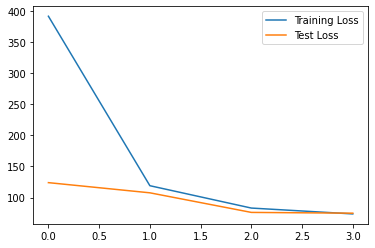

[5,     1] loss: 81.135
[5,     2] loss: 69.321
[5,     3] loss: 72.484
[5,     4] loss: 74.276
[5,     5] loss: 73.140
[5,     6] loss: 67.115
[5,     7] loss: 66.898
[5,     8] loss: 71.585
[5,     9] loss: 67.161
[5,    10] loss: 67.242
[5,    11] loss: 66.873
[5,    12] loss: 69.104
[5,    13] loss: 77.544
[5,    14] loss: 68.479
[5,    15] loss: 70.760
[5,    16] loss: 68.705
[5,    17] loss: 69.314
[5,    18] loss: 71.750
[5,    19] loss: 72.221
[5,    20] loss: 64.680
[5,    21] loss: 77.200
[5,    22] loss: 63.586
[5,    23] loss: 61.887
[5,    24] loss: 67.734
[5,    25] loss: 73.369
[5,    26] loss: 62.893
[5,    27] loss: 68.699
[5,    28] loss: 71.318
[5,    29] loss: 83.324
[5,    30] loss: 68.281
[5,    31] loss: 68.517
[5,    32] loss: 75.048
[5,    33] loss: 69.186
LOSS of the network on the train images after epoch 4 is 2320.828079223633
Mean of the network on the train images after epoch 4 is 72.52587747573853
LOSS of the network on the test images: 1037 %
Mean of the

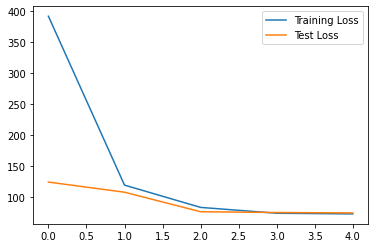

[6,     1] loss: 80.296
[6,     2] loss: 68.684
[6,     3] loss: 71.465
[6,     4] loss: 73.374
[6,     5] loss: 72.357
[6,     6] loss: 66.431
[6,     7] loss: 66.139
[6,     8] loss: 70.791
[6,     9] loss: 66.413
[6,    10] loss: 66.431
[6,    11] loss: 65.844
[6,    12] loss: 68.141
[6,    13] loss: 76.685
[6,    14] loss: 67.660
[6,    15] loss: 69.992
[6,    16] loss: 67.908
[6,    17] loss: 68.645
[6,    18] loss: 71.030
[6,    19] loss: 71.297
[6,    20] loss: 63.637
[6,    21] loss: 76.371
[6,    22] loss: 62.736
[6,    23] loss: 61.333
[6,    24] loss: 67.055
[6,    25] loss: 72.301
[6,    26] loss: 62.531
[6,    27] loss: 67.632
[6,    28] loss: 70.571
[6,    29] loss: 82.419
[6,    30] loss: 67.489
[6,    31] loss: 67.972
[6,    32] loss: 74.107
[6,    33] loss: 68.570
LOSS of the network on the train images after epoch 5 is 2294.3059577941895
Mean of the network on the train images after epoch 5 is 71.69706118106842
LOSS of the network on the test images: 1026 %
Mean of th

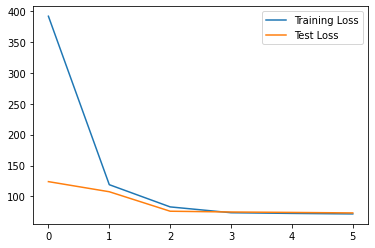

[7,     1] loss: 79.388
[7,     2] loss: 67.820
[7,     3] loss: 70.556
[7,     4] loss: 72.452
[7,     5] loss: 71.501
[7,     6] loss: 65.707
[7,     7] loss: 65.324
[7,     8] loss: 69.949
[7,     9] loss: 65.809
[7,    10] loss: 65.458
[7,    11] loss: 64.749
[7,    12] loss: 67.061
[7,    13] loss: 75.880
[7,    14] loss: 66.834
[7,    15] loss: 69.189
[7,    16] loss: 67.004
[7,    17] loss: 67.978
[7,    18] loss: 70.131
[7,    19] loss: 70.319
[7,    20] loss: 62.418
[7,    21] loss: 75.530
[7,    22] loss: 61.880
[7,    23] loss: 60.755
[7,    24] loss: 66.394
[7,    25] loss: 71.051
[7,    26] loss: 62.036
[7,    27] loss: 66.432
[7,    28] loss: 69.288
[7,    29] loss: 81.508
[7,    30] loss: 66.700
[7,    31] loss: 66.687
[7,    32] loss: 73.164
[7,    33] loss: 67.784
LOSS of the network on the train images after epoch 6 is 2264.7362480163574
Mean of the network on the train images after epoch 6 is 70.77300775051117
LOSS of the network on the test images: 1010 %
Mean of th

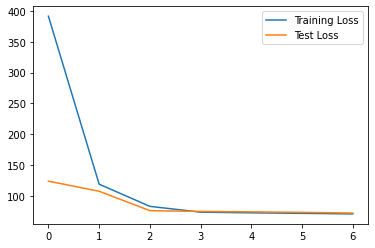

[8,     1] loss: 78.099
[8,     2] loss: 67.089
[8,     3] loss: 68.874
[8,     4] loss: 71.115
[8,     5] loss: 70.454
[8,     6] loss: 64.446
[8,     7] loss: 64.117
[8,     8] loss: 68.837
[8,     9] loss: 64.670
[8,    10] loss: 64.067
[8,    11] loss: 62.693
[8,    12] loss: 65.291
[8,    13] loss: 74.455
[8,    14] loss: 65.126
[8,    15] loss: 67.964
[8,    16] loss: 65.278
[8,    17] loss: 66.319
[8,    18] loss: 68.799
[8,    19] loss: 68.581
[8,    20] loss: 60.504
[8,    21] loss: 73.017
[8,    22] loss: 60.187
[8,    23] loss: 59.920
[8,    24] loss: 64.883
[8,    25] loss: 68.960
[8,    26] loss: 60.955
[8,    27] loss: 64.284
[8,    28] loss: 66.906
[8,    29] loss: 79.700
[8,    30] loss: 65.411
[8,    31] loss: 64.693
[8,    32] loss: 70.316
[8,    33] loss: 66.443
LOSS of the network on the train images after epoch 7 is 2212.4566688537598
Mean of the network on the train images after epoch 7 is 69.13927090167999
LOSS of the network on the test images: 981 %
Mean of the

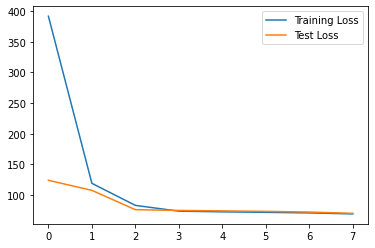

[9,     1] loss: 75.419
[9,     2] loss: 65.331
[9,     3] loss: 66.460
[9,     4] loss: 68.213
[9,     5] loss: 68.083
[9,     6] loss: 62.222
[9,     7] loss: 61.394
[9,     8] loss: 66.962
[9,     9] loss: 62.442
[9,    10] loss: 61.539
[9,    11] loss: 59.573
[9,    12] loss: 62.556
[9,    13] loss: 71.517
[9,    14] loss: 62.642
[9,    15] loss: 65.290
[9,    16] loss: 63.011
[9,    17] loss: 63.366
[9,    18] loss: 66.440
[9,    19] loss: 65.766
[9,    20] loss: 58.869
[9,    21] loss: 70.389
[9,    22] loss: 58.272
[9,    23] loss: 59.253
[9,    24] loss: 62.555
[9,    25] loss: 65.985
[9,    26] loss: 60.242
[9,    27] loss: 62.853
[9,    28] loss: 63.766
[9,    29] loss: 78.242
[9,    30] loss: 64.459
[9,    31] loss: 61.583
[9,    32] loss: 67.518
[9,    33] loss: 65.377
LOSS of the network on the train images after epoch 8 is 2137.588466644287
Mean of the network on the train images after epoch 8 is 66.79963958263397
LOSS of the network on the test images: 951 %
Mean of the 

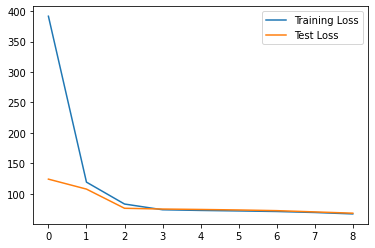

[10,     1] loss: 72.471
[10,     2] loss: 65.747
[10,     3] loss: 64.649
[10,     4] loss: 65.479
[10,     5] loss: 66.160
[10,     6] loss: 59.942
[10,     7] loss: 59.640
[10,     8] loss: 64.875
[10,     9] loss: 61.396
[10,    10] loss: 60.646
[10,    11] loss: 57.273
[10,    12] loss: 60.727
[10,    13] loss: 69.386
[10,    14] loss: 60.882
[10,    15] loss: 63.101
[10,    16] loss: 61.106
[10,    17] loss: 61.144
[10,    18] loss: 64.759
[10,    19] loss: 63.663
[10,    20] loss: 56.985
[10,    21] loss: 67.513
[10,    22] loss: 56.911
[10,    23] loss: 57.259
[10,    24] loss: 60.488
[10,    25] loss: 64.089
[10,    26] loss: 57.893
[10,    27] loss: 60.999
[10,    28] loss: 62.034
[10,    29] loss: 75.686
[10,    30] loss: 62.283
[10,    31] loss: 59.999
[10,    32] loss: 64.886
[10,    33] loss: 64.399
LOSS of the network on the train images after epoch 9 is 2074.4707565307617
Mean of the network on the train images after epoch 9 is 64.8272111415863
LOSS of the network on th

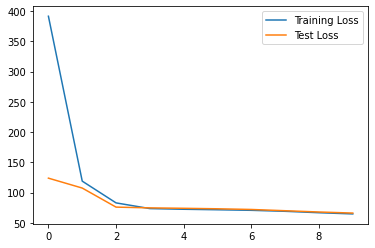

[11,     1] loss: 69.883
[11,     2] loss: 62.333
[11,     3] loss: 62.960
[11,     4] loss: 63.583
[11,     5] loss: 62.714
[11,     6] loss: 58.655
[11,     7] loss: 57.279
[11,     8] loss: 63.395
[11,     9] loss: 59.639
[11,    10] loss: 58.668
[11,    11] loss: 56.103
[11,    12] loss: 58.528
[11,    13] loss: 68.328
[11,    14] loss: 60.238
[11,    15] loss: 61.269
[11,    16] loss: 60.117
[11,    17] loss: 59.478
[11,    18] loss: 62.982
[11,    19] loss: 62.652
[11,    20] loss: 55.653
[11,    21] loss: 66.522
[11,    22] loss: 55.859
[11,    23] loss: 55.911
[11,    24] loss: 58.588
[11,    25] loss: 62.428
[11,    26] loss: 56.546
[11,    27] loss: 59.200
[11,    28] loss: 59.117
[11,    29] loss: 73.079
[11,    30] loss: 60.196
[11,    31] loss: 57.840
[11,    32] loss: 62.898
[11,    33] loss: 61.593
LOSS of the network on the train images after epoch 10 is 2014.23588180542
Mean of the network on the train images after epoch 10 is 62.94487130641937
LOSS of the network on t

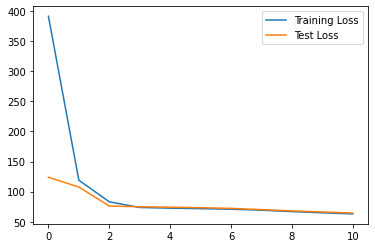

[12,     1] loss: 66.909
[12,     2] loss: 60.561
[12,     3] loss: 60.413
[12,     4] loss: 61.248
[12,     5] loss: 60.313
[12,     6] loss: 56.455
[12,     7] loss: 54.902
[12,     8] loss: 61.006
[12,     9] loss: 57.189
[12,    10] loss: 56.413
[12,    11] loss: 54.069
[12,    12] loss: 56.829
[12,    13] loss: 65.111
[12,    14] loss: 57.014
[12,    15] loss: 59.275
[12,    16] loss: 57.380
[12,    17] loss: 55.776
[12,    18] loss: 59.797
[12,    19] loss: 59.781
[12,    20] loss: 55.201
[12,    21] loss: 64.552
[12,    22] loss: 53.856
[12,    23] loss: 54.796
[12,    24] loss: 56.105
[12,    25] loss: 60.709
[12,    26] loss: 56.088
[12,    27] loss: 58.932
[12,    28] loss: 55.480
[12,    29] loss: 70.316
[12,    30] loss: 59.856
[12,    31] loss: 56.188
[12,    32] loss: 60.988
[12,    33] loss: 59.186
LOSS of the network on the train images after epoch 11 is 1942.6940155029297
Mean of the network on the train images after epoch 11 is 60.70918798446655
LOSS of the network on

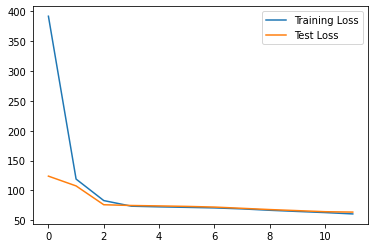

[13,     1] loss: 64.862
[13,     2] loss: 60.451
[13,     3] loss: 58.139
[13,     4] loss: 60.688
[13,     5] loss: 59.435
[13,     6] loss: 54.141
[13,     7] loss: 53.634
[13,     8] loss: 59.937
[13,     9] loss: 55.156
[13,    10] loss: 54.773
[13,    11] loss: 53.709
[13,    12] loss: 55.119
[13,    13] loss: 61.982
[13,    14] loss: 56.444
[13,    15] loss: 58.630
[13,    16] loss: 55.608
[13,    17] loss: 53.616
[13,    18] loss: 57.893
[13,    19] loss: 58.244
[13,    20] loss: 52.199
[13,    21] loss: 61.257
[13,    22] loss: 52.544
[13,    23] loss: 51.631
[13,    24] loss: 53.132
[13,    25] loss: 59.875
[13,    26] loss: 52.240
[13,    27] loss: 54.796
[13,    28] loss: 54.026
[13,    29] loss: 67.134
[13,    30] loss: 59.534
[13,    31] loss: 55.548
[13,    32] loss: 60.406
[13,    33] loss: 61.011
LOSS of the network on the train images after epoch 12 is 1887.7943992614746
Mean of the network on the train images after epoch 12 is 58.99357497692108
LOSS of the network on

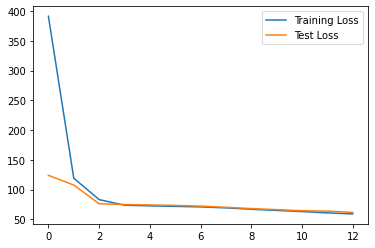

[14,     1] loss: 62.215
[14,     2] loss: 60.633
[14,     3] loss: 57.063
[14,     4] loss: 58.829
[14,     5] loss: 58.347
[14,     6] loss: 52.913
[14,     7] loss: 52.310
[14,     8] loss: 57.752
[14,     9] loss: 53.493
[14,    10] loss: 53.220
[14,    11] loss: 51.314
[14,    12] loss: 53.074
[14,    13] loss: 60.563
[14,    14] loss: 54.413
[14,    15] loss: 56.773
[14,    16] loss: 54.658
[14,    17] loss: 52.064
[14,    18] loss: 56.126
[14,    19] loss: 56.920
[14,    20] loss: 50.946
[14,    21] loss: 59.008
[14,    22] loss: 51.006
[14,    23] loss: 50.044
[14,    24] loss: 51.895
[14,    25] loss: 58.113
[14,    26] loss: 51.477
[14,    27] loss: 53.500
[14,    28] loss: 52.332
[14,    29] loss: 65.957
[14,    30] loss: 56.511
[14,    31] loss: 52.610
[14,    32] loss: 57.563
[14,    33] loss: 55.030
LOSS of the network on the train images after epoch 13 is 1828.6727714538574
Mean of the network on the train images after epoch 13 is 57.146024107933044
LOSS of the network o

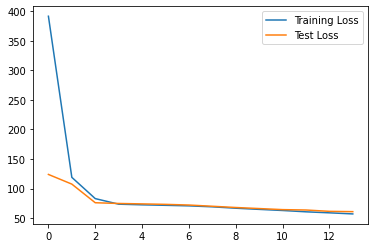

[15,     1] loss: 61.280
[15,     2] loss: 57.375
[15,     3] loss: 55.172
[15,     4] loss: 59.047
[15,     5] loss: 55.452
[15,     6] loss: 52.393
[15,     7] loss: 50.718
[15,     8] loss: 56.788
[15,     9] loss: 52.012
[15,    10] loss: 52.466
[15,    11] loss: 50.260
[15,    12] loss: 52.034
[15,    13] loss: 59.293
[15,    14] loss: 53.381
[15,    15] loss: 56.161
[15,    16] loss: 53.492
[15,    17] loss: 51.223
[15,    18] loss: 54.988
[15,    19] loss: 55.721
[15,    20] loss: 49.720
[15,    21] loss: 58.051
[15,    22] loss: 49.843
[15,    23] loss: 48.909
[15,    24] loss: 50.716
[15,    25] loss: 56.758
[15,    26] loss: 50.350
[15,    27] loss: 52.367
[15,    28] loss: 51.352
[15,    29] loss: 63.421
[15,    30] loss: 55.160
[15,    31] loss: 51.484
[15,    32] loss: 56.018
[15,    33] loss: 53.955
LOSS of the network on the train images after epoch 14 is 1787.3589363098145
Mean of the network on the train images after epoch 14 is 55.8549667596817
LOSS of the network on 

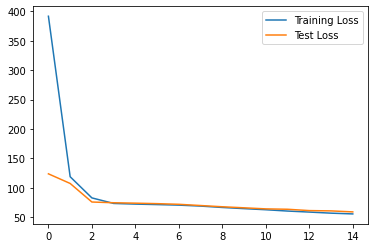

[16,     1] loss: 59.346
[16,     2] loss: 55.238
[16,     3] loss: 54.157
[16,     4] loss: 56.549
[16,     5] loss: 54.057
[16,     6] loss: 51.202
[16,     7] loss: 49.871
[16,     8] loss: 55.366
[16,     9] loss: 51.223
[16,    10] loss: 51.560
[16,    11] loss: 49.242
[16,    12] loss: 50.861
[16,    13] loss: 57.753
[16,    14] loss: 52.486
[16,    15] loss: 54.911
[16,    16] loss: 52.408
[16,    17] loss: 50.278
[16,    18] loss: 53.865
[16,    19] loss: 54.751
[16,    20] loss: 48.994
[16,    21] loss: 56.861
[16,    22] loss: 49.030
[16,    23] loss: 48.055
[16,    24] loss: 49.824
[16,    25] loss: 55.682
[16,    26] loss: 49.741
[16,    27] loss: 51.475
[16,    28] loss: 50.531
[16,    29] loss: 61.903
[16,    30] loss: 54.190
[16,    31] loss: 50.717
[16,    32] loss: 54.870
[16,    33] loss: 53.162
LOSS of the network on the train images after epoch 15 is 1750.1573181152344
Mean of the network on the train images after epoch 15 is 54.692416191101074
LOSS of the network o

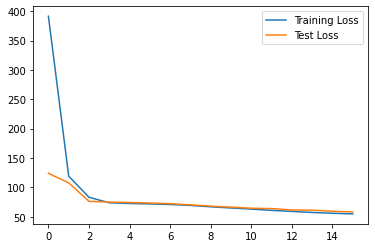

[17,     1] loss: 57.995
[17,     2] loss: 53.893
[17,     3] loss: 53.326
[17,     4] loss: 54.840
[17,     5] loss: 53.133
[17,     6] loss: 50.426
[17,     7] loss: 48.887
[17,     8] loss: 54.544
[17,     9] loss: 50.473
[17,    10] loss: 50.900
[17,    11] loss: 48.824
[17,    12] loss: 50.110
[17,    13] loss: 56.784
[17,    14] loss: 51.844
[17,    15] loss: 54.042
[17,    16] loss: 51.556
[17,    17] loss: 49.664
[17,    18] loss: 53.057
[17,    19] loss: 54.159
[17,    20] loss: 48.172
[17,    21] loss: 56.141
[17,    22] loss: 48.702
[17,    23] loss: 47.137
[17,    24] loss: 49.293
[17,    25] loss: 54.857
[17,    26] loss: 49.013
[17,    27] loss: 50.756
[17,    28] loss: 49.897
[17,    29] loss: 60.828
[17,    30] loss: 53.474
[17,    31] loss: 49.758
[17,    32] loss: 54.140
[17,    33] loss: 52.193
LOSS of the network on the train images after epoch 16 is 1722.8169021606445
Mean of the network on the train images after epoch 16 is 53.83802819252014
LOSS of the network on

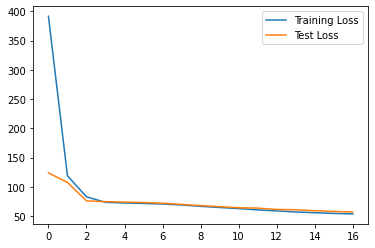

[18,     1] loss: 57.042
[18,     2] loss: 52.820
[18,     3] loss: 52.410
[18,     4] loss: 53.958
[18,     5] loss: 52.435
[18,     6] loss: 49.520
[18,     7] loss: 48.057
[18,     8] loss: 53.731
[18,     9] loss: 49.646
[18,    10] loss: 50.271
[18,    11] loss: 48.152
[18,    12] loss: 49.251
[18,    13] loss: 56.042
[18,    14] loss: 50.940
[18,    15] loss: 53.161
[18,    16] loss: 50.863
[18,    17] loss: 48.832
[18,    18] loss: 52.231
[18,    19] loss: 53.267
[18,    20] loss: 47.254
[18,    21] loss: 54.912
[18,    22] loss: 47.819
[18,    23] loss: 46.187
[18,    24] loss: 48.442
[18,    25] loss: 53.878
[18,    26] loss: 48.718
[18,    27] loss: 50.005
[18,    28] loss: 49.613
[18,    29] loss: 60.770
[18,    30] loss: 53.216
[18,    31] loss: 49.104
[18,    32] loss: 53.147
[18,    33] loss: 51.506
LOSS of the network on the train images after epoch 17 is 1697.2010116577148
Mean of the network on the train images after epoch 17 is 53.03753161430359
LOSS of the network on

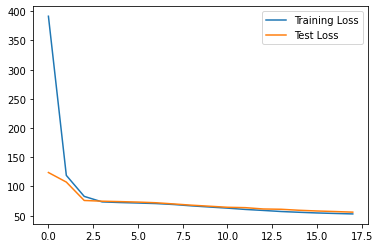

[19,     1] loss: 56.137
[19,     2] loss: 51.793
[19,     3] loss: 51.614
[19,     4] loss: 52.820
[19,     5] loss: 51.526
[19,     6] loss: 48.640
[19,     7] loss: 47.244
[19,     8] loss: 52.603
[19,     9] loss: 48.756
[19,    10] loss: 49.303
[19,    11] loss: 47.268
[19,    12] loss: 48.412
[19,    13] loss: 54.719
[19,    14] loss: 49.733
[19,    15] loss: 52.259
[19,    16] loss: 49.827
[19,    17] loss: 47.833
[19,    18] loss: 51.138
[19,    19] loss: 52.149
[19,    20] loss: 46.210
[19,    21] loss: 53.228
[19,    22] loss: 46.921
[19,    23] loss: 45.294
[19,    24] loss: 47.513
[19,    25] loss: 52.144
[19,    26] loss: 47.457
[19,    27] loss: 48.886
[19,    28] loss: 48.331
[19,    29] loss: 58.275
[19,    30] loss: 51.858
[19,    31] loss: 48.346
[19,    32] loss: 52.031
[19,    33] loss: 50.166
LOSS of the network on the train images after epoch 18 is 1660.4355087280273
Mean of the network on the train images after epoch 18 is 51.888609647750854
LOSS of the network o

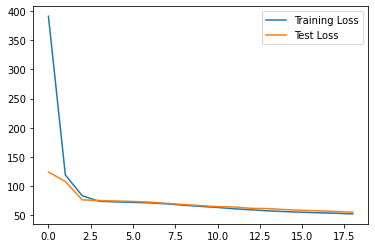

[20,     1] loss: 55.083
[20,     2] loss: 50.699
[20,     3] loss: 50.680
[20,     4] loss: 51.546
[20,     5] loss: 50.547
[20,     6] loss: 47.651
[20,     7] loss: 46.322
[20,     8] loss: 51.160
[20,     9] loss: 47.729
[20,    10] loss: 48.183
[20,    11] loss: 46.204
[20,    12] loss: 47.362
[20,    13] loss: 53.332
[20,    14] loss: 48.395
[20,    15] loss: 51.056
[20,    16] loss: 48.764
[20,    17] loss: 46.718
[20,    18] loss: 49.833
[20,    19] loss: 51.313
[20,    20] loss: 45.442
[20,    21] loss: 51.731
[20,    22] loss: 45.893
[20,    23] loss: 44.354
[20,    24] loss: 46.892
[20,    25] loss: 50.446
[20,    26] loss: 46.504
[20,    27] loss: 47.908
[20,    28] loss: 47.410
[20,    29] loss: 56.196
[20,    30] loss: 50.130
[20,    31] loss: 47.225
[20,    32] loss: 50.934
[20,    33] loss: 48.916
LOSS of the network on the train images after epoch 19 is 1622.5604934692383
Mean of the network on the train images after epoch 19 is 50.705015420913696
LOSS of the network o

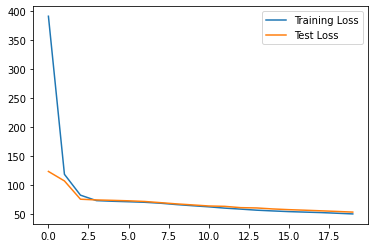

[21,     1] loss: 53.799
[21,     2] loss: 49.357
[21,     3] loss: 50.123
[21,     4] loss: 50.420
[21,     5] loss: 49.425
[21,     6] loss: 46.691
[21,     7] loss: 45.403
[21,     8] loss: 49.948
[21,     9] loss: 46.837
[21,    10] loss: 47.043
[21,    11] loss: 45.626
[21,    12] loss: 46.283
[21,    13] loss: 52.343
[21,    14] loss: 47.206
[21,    15] loss: 50.088
[21,    16] loss: 47.956
[21,    17] loss: 45.590
[21,    18] loss: 48.608
[21,    19] loss: 49.870
[21,    20] loss: 44.213
[21,    21] loss: 50.927
[21,    22] loss: 44.763
[21,    23] loss: 43.585
[21,    24] loss: 45.737
[21,    25] loss: 49.679
[21,    26] loss: 45.074
[21,    27] loss: 47.179
[21,    28] loss: 46.075
[21,    29] loss: 54.933
[21,    30] loss: 48.237
[21,    31] loss: 46.136
[21,    32] loss: 49.338
[21,    33] loss: 48.123
LOSS of the network on the train images after epoch 20 is 1586.6169128417969
Mean of the network on the train images after epoch 20 is 49.58177852630615
LOSS of the network on

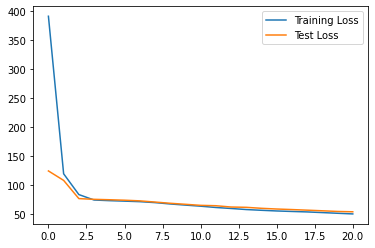

[22,     1] loss: 52.638
[22,     2] loss: 48.834
[22,     3] loss: 49.190
[22,     4] loss: 49.076
[22,     5] loss: 48.424
[22,     6] loss: 45.947
[22,     7] loss: 44.243
[22,     8] loss: 49.312
[22,     9] loss: 45.984
[22,    10] loss: 46.283
[22,    11] loss: 44.938
[22,    12] loss: 45.421
[22,    13] loss: 51.422
[22,    14] loss: 46.199
[22,    15] loss: 49.186
[22,    16] loss: 47.251
[22,    17] loss: 44.615
[22,    18] loss: 47.867
[22,    19] loss: 48.944
[22,    20] loss: 43.466
[22,    21] loss: 50.116
[22,    22] loss: 43.970
[22,    23] loss: 42.957
[22,    24] loss: 44.834
[22,    25] loss: 48.802
[22,    26] loss: 44.512
[22,    27] loss: 46.732
[22,    28] loss: 45.453
[22,    29] loss: 53.715
[22,    30] loss: 47.438
[22,    31] loss: 45.257
[22,    32] loss: 48.534
[22,    33] loss: 47.217
LOSS of the network on the train images after epoch 21 is 1558.7769508361816
Mean of the network on the train images after epoch 21 is 48.711779713630676
LOSS of the network o

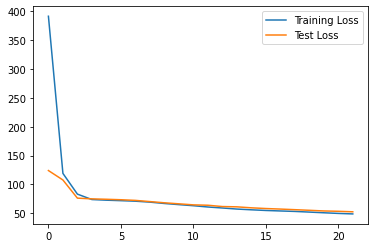

[23,     1] loss: 51.503
[23,     2] loss: 47.794
[23,     3] loss: 47.876
[23,     4] loss: 47.957
[23,     5] loss: 47.350
[23,     6] loss: 44.933
[23,     7] loss: 43.673
[23,     8] loss: 47.907
[23,     9] loss: 45.276
[23,    10] loss: 45.117
[23,    11] loss: 44.129
[23,    12] loss: 44.593
[23,    13] loss: 50.105
[23,    14] loss: 45.369
[23,    15] loss: 47.892
[23,    16] loss: 46.534
[23,    17] loss: 43.708
[23,    18] loss: 46.805
[23,    19] loss: 47.950
[23,    20] loss: 42.474
[23,    21] loss: 49.218
[23,    22] loss: 42.967
[23,    23] loss: 42.155
[23,    24] loss: 44.177
[23,    25] loss: 47.503
[23,    26] loss: 43.341
[23,    27] loss: 45.542
[23,    28] loss: 44.547
[23,    29] loss: 52.638
[23,    30] loss: 46.426
[23,    31] loss: 44.390
[23,    32] loss: 47.270
[23,    33] loss: 46.404
LOSS of the network on the train images after epoch 22 is 1525.5233764648438
Mean of the network on the train images after epoch 22 is 47.67260551452637
LOSS of the network on

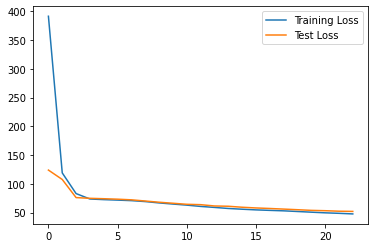

[24,     1] loss: 50.766
[24,     2] loss: 47.286
[24,     3] loss: 46.966
[24,     4] loss: 47.006
[24,     5] loss: 47.732
[24,     6] loss: 45.729
[24,     7] loss: 44.551
[24,     8] loss: 47.112
[24,     9] loss: 44.754
[24,    10] loss: 45.404
[24,    11] loss: 43.915
[24,    12] loss: 44.163
[24,    13] loss: 49.136
[24,    14] loss: 45.279
[24,    15] loss: 47.949
[24,    16] loss: 45.978
[24,    17] loss: 43.311
[24,    18] loss: 46.738
[24,    19] loss: 48.073
[24,    20] loss: 41.974
[24,    21] loss: 49.179
[24,    22] loss: 43.503
[24,    23] loss: 41.957
[24,    24] loss: 44.797
[24,    25] loss: 48.146
[24,    26] loss: 43.940
[24,    27] loss: 45.042
[24,    28] loss: 44.825
[24,    29] loss: 52.410
[24,    30] loss: 46.953
[24,    31] loss: 44.112
[24,    32] loss: 47.115
[24,    33] loss: 45.624
LOSS of the network on the train images after epoch 23 is 1521.4244918823242
Mean of the network on the train images after epoch 23 is 47.54451537132263
LOSS of the network on

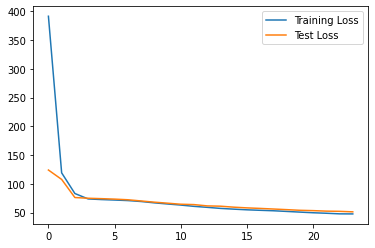

[25,     1] loss: 49.698
[25,     2] loss: 46.372
[25,     3] loss: 46.475
[25,     4] loss: 46.277
[25,     5] loss: 46.184
[25,     6] loss: 43.539
[25,     7] loss: 43.323
[25,     8] loss: 46.708
[25,     9] loss: 43.646
[25,    10] loss: 44.549
[25,    11] loss: 42.845
[25,    12] loss: 43.346
[25,    13] loss: 48.921
[25,    14] loss: 44.690
[25,    15] loss: 46.541
[25,    16] loss: 45.557
[25,    17] loss: 43.619
[25,    18] loss: 45.681
[25,    19] loss: 46.319
[25,    20] loss: 42.009
[25,    21] loss: 47.188
[25,    22] loss: 41.619
[25,    23] loss: 40.490
[25,    24] loss: 42.696
[25,    25] loss: 45.695
[25,    26] loss: 41.982
[25,    27] loss: 43.984
[25,    28] loss: 42.754
[25,    29] loss: 50.328
[25,    30] loss: 44.573
[25,    31] loss: 42.969
[25,    32] loss: 45.436
[25,    33] loss: 44.104
LOSS of the network on the train images after epoch 24 is 1480.1177597045898
Mean of the network on the train images after epoch 24 is 46.25367999076843
LOSS of the network on

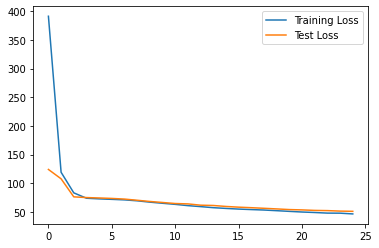

[26,     1] loss: 48.623
[26,     2] loss: 45.063
[26,     3] loss: 45.129
[26,     4] loss: 45.198
[26,     5] loss: 44.837
[26,     6] loss: 42.453
[26,     7] loss: 41.918
[26,     8] loss: 45.893
[26,     9] loss: 42.804
[26,    10] loss: 43.342
[26,    11] loss: 42.506
[26,    12] loss: 42.610
[26,    13] loss: 47.680
[26,    14] loss: 43.827
[26,    15] loss: 45.316
[26,    16] loss: 44.824
[26,    17] loss: 42.351
[26,    18] loss: 44.637
[26,    19] loss: 45.443
[26,    20] loss: 41.053
[26,    21] loss: 46.152
[26,    22] loss: 40.591
[26,    23] loss: 39.545
[26,    24] loss: 42.046
[26,    25] loss: 44.752
[26,    26] loss: 41.173
[26,    27] loss: 43.188
[26,    28] loss: 41.914
[26,    29] loss: 49.194
[26,    30] loss: 43.585
[26,    31] loss: 41.930
[26,    32] loss: 44.416
[26,    33] loss: 42.971
LOSS of the network on the train images after epoch 25 is 1446.9649505615234
Mean of the network on the train images after epoch 25 is 45.21765470504761
LOSS of the network on

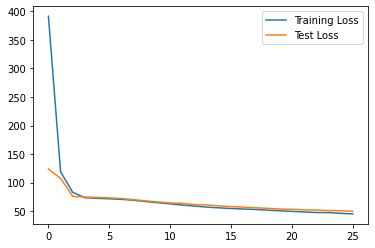

[27,     1] loss: 47.243
[27,     2] loss: 43.893
[27,     3] loss: 44.203
[27,     4] loss: 43.865
[27,     5] loss: 43.418
[27,     6] loss: 41.726
[27,     7] loss: 40.814
[27,     8] loss: 44.641
[27,     9] loss: 41.956
[27,    10] loss: 42.345
[27,    11] loss: 41.168
[27,    12] loss: 41.994
[27,    13] loss: 46.075
[27,    14] loss: 42.330
[27,    15] loss: 44.242
[27,    16] loss: 43.581
[27,    17] loss: 40.565
[27,    18] loss: 43.496
[27,    19] loss: 44.304
[27,    20] loss: 39.935
[27,    21] loss: 45.033
[27,    22] loss: 39.681
[27,    23] loss: 38.588
[27,    24] loss: 41.127
[27,    25] loss: 43.540
[27,    26] loss: 40.341
[27,    27] loss: 42.189
[27,    28] loss: 40.963
[27,    29] loss: 47.931
[27,    30] loss: 42.636
[27,    31] loss: 41.132
[27,    32] loss: 43.551
[27,    33] loss: 41.854
LOSS of the network on the train images after epoch 26 is 1410.3595161437988
Mean of the network on the train images after epoch 26 is 44.07373487949371
LOSS of the network on

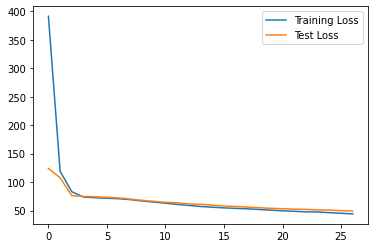

[28,     1] loss: 46.009
[28,     2] loss: 42.933
[28,     3] loss: 43.018
[28,     4] loss: 42.517
[28,     5] loss: 42.399
[28,     6] loss: 41.010
[28,     7] loss: 39.932
[28,     8] loss: 43.530
[28,     9] loss: 41.319
[28,    10] loss: 41.190
[28,    11] loss: 40.156
[28,    12] loss: 41.119
[28,    13] loss: 44.861
[28,    14] loss: 41.125
[28,    15] loss: 43.392
[28,    16] loss: 42.607
[28,    17] loss: 39.515
[28,    18] loss: 42.500
[28,    19] loss: 43.412
[28,    20] loss: 38.831
[28,    21] loss: 44.025
[28,    22] loss: 38.853
[28,    23] loss: 37.717
[28,    24] loss: 40.362
[28,    25] loss: 42.505
[28,    26] loss: 39.876
[28,    27] loss: 41.465
[28,    28] loss: 40.300
[28,    29] loss: 46.878
[28,    30] loss: 41.797
[28,    31] loss: 40.239
[28,    32] loss: 42.962
[28,    33] loss: 41.254
LOSS of the network on the train images after epoch 27 is 1379.6118545532227
Mean of the network on the train images after epoch 27 is 43.11287045478821
LOSS of the network on

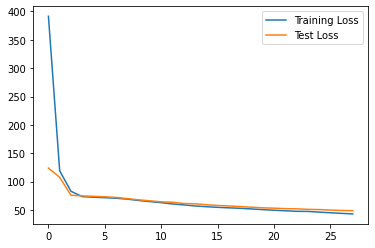

[29,     1] loss: 45.252
[29,     2] loss: 42.257
[29,     3] loss: 42.350
[29,     4] loss: 41.696
[29,     5] loss: 41.670
[29,     6] loss: 40.275
[29,     7] loss: 39.506
[29,     8] loss: 42.461
[29,     9] loss: 40.720
[29,    10] loss: 40.334
[29,    11] loss: 39.668
[29,    12] loss: 40.377
[29,    13] loss: 43.948
[29,    14] loss: 40.447
[29,    15] loss: 42.614
[29,    16] loss: 42.311
[29,    17] loss: 39.158
[29,    18] loss: 41.974
[29,    19] loss: 42.889
[29,    20] loss: 38.356
[29,    21] loss: 43.128
[29,    22] loss: 38.156
[29,    23] loss: 36.903
[29,    24] loss: 39.597
[29,    25] loss: 41.671
[29,    26] loss: 39.142
[29,    27] loss: 40.941
[29,    28] loss: 39.532
[29,    29] loss: 45.696
[29,    30] loss: 40.710
[29,    31] loss: 39.752
[29,    32] loss: 42.758
[29,    33] loss: 40.560
LOSS of the network on the train images after epoch 28 is 1356.8088417053223
Mean of the network on the train images after epoch 28 is 42.40027630329132
LOSS of the network on

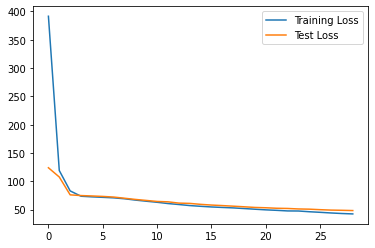

[30,     1] loss: 44.260
[30,     2] loss: 41.051
[30,     3] loss: 41.350
[30,     4] loss: 41.463
[30,     5] loss: 41.159
[30,     6] loss: 39.915
[30,     7] loss: 38.756
[30,     8] loss: 41.787
[30,     9] loss: 40.848
[30,    10] loss: 40.737
[30,    11] loss: 39.224
[30,    12] loss: 40.085
[30,    13] loss: 44.329
[30,    14] loss: 41.442
[30,    15] loss: 41.469
[30,    16] loss: 41.470
[30,    17] loss: 38.625
[30,    18] loss: 41.950
[30,    19] loss: 42.077
[30,    20] loss: 37.993
[30,    21] loss: 42.492
[30,    22] loss: 37.619
[30,    23] loss: 36.469
[30,    24] loss: 39.674
[30,    25] loss: 42.302
[30,    26] loss: 39.842
[30,    27] loss: 40.423
[30,    28] loss: 38.896
[30,    29] loss: 44.473
[30,    30] loss: 40.487
[30,    31] loss: 38.918
[30,    32] loss: 41.174
[30,    33] loss: 40.143
LOSS of the network on the train images after epoch 29 is 1342.9006423950195
Mean of the network on the train images after epoch 29 is 41.96564507484436
LOSS of the network on

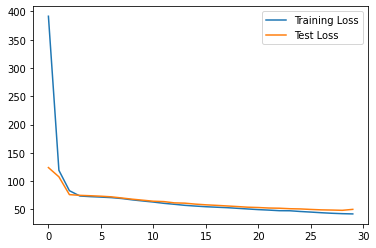

Finished Training


In [36]:
train_loss_graph = []
test_loss_graph = []

indian_loss_graph = []
western_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
      
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)

print('Finished Training')

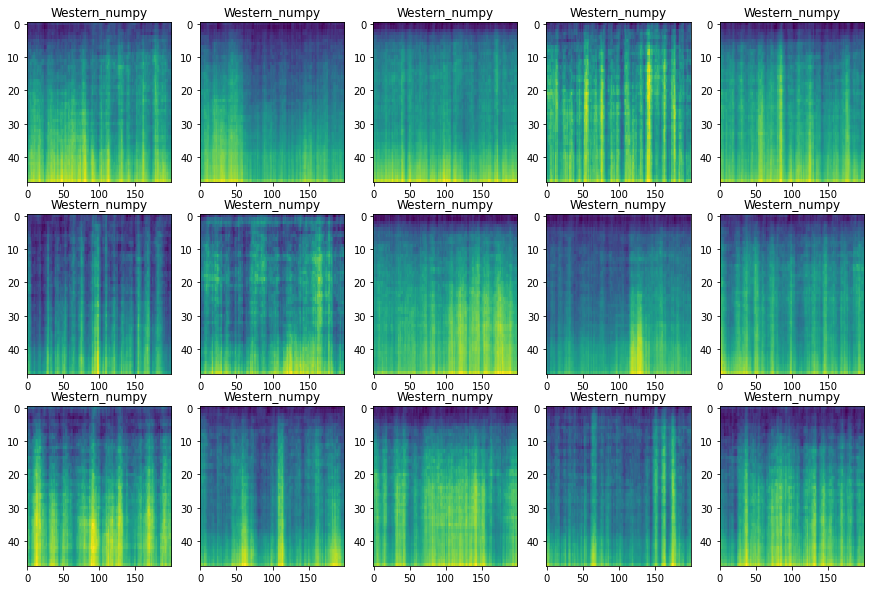

In [37]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

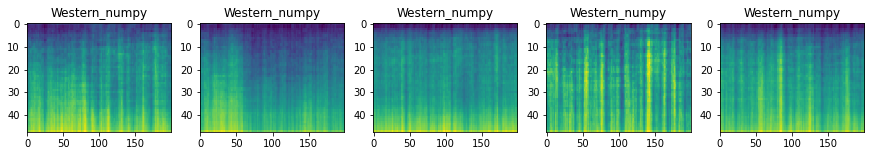

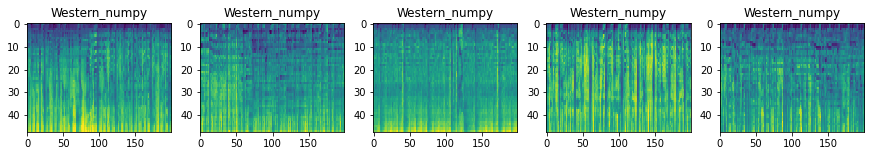

In [38]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [39]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [40]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Strict data separation

In [41]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    #print("removing ", os.path.join(dir, f))
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


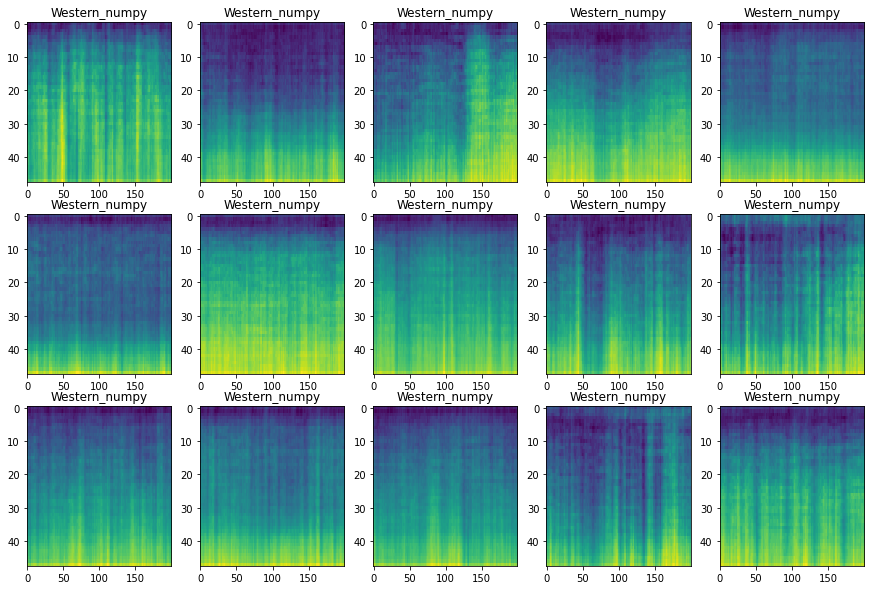

In [42]:
# get some random training images
dataiter = iter(trainloader_combined)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

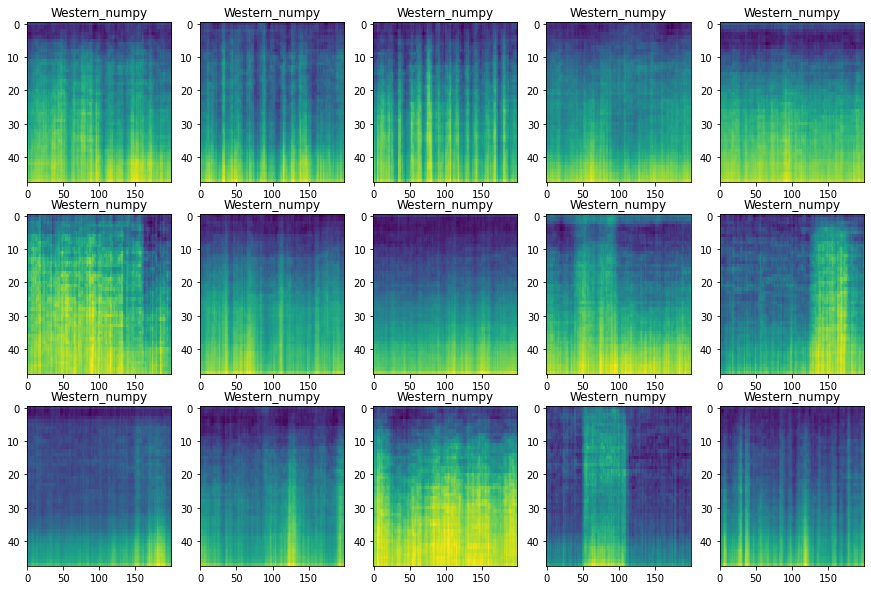

In [43]:
# get some random training images
dataiter = iter(testloader_combined)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [44]:
id_test = 0
with torch.no_grad():
    for data_test in testloader_combined:
        inputs, labels, fileNames = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/test/Western_numpy/western_036257_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/test/Western_numpy/western_126218_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/test/Western_numpy/western_085833_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/test/Western_numpy/western_129970_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/test/Western_numpy/western_118735_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/test/Western_numpy/western_150288_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/test/Western_numpy/western_105411_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/test/Western_numpy/western_114279_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/test/Western_numpy/western_123964_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN

In [45]:
id_train = 0
with torch.no_grad():
    for data in trainloader_combined:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_train = id_train + 1

Streaming output truncated to the last 5000 lines.
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/training/Western_numpy/western_134931_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/training/Western_numpy/western_039900_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/training/Western_numpy/western_038353_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/training/Western_numpy/western_093917_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/training/Western_numpy/western_140609_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/training/Western_numpy/western_003598_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/training/Western_numpy/western_140260_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/training/Western_numpy/western_066636_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_GTZAN/Activations_64/trainin